In [49]:
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from plotnine import (
    ggplot, geom_point, geom_jitter, geom_line, geom_smooth, geom_ribbon, geom_rect, geom_boxplot,
    aes, facet_wrap, theme_bw, theme_void, theme_matplotlib, theme_linedraw, theme_minimal, theme_seaborn,
    theme, ylim, ggtitle, scale_color_brewer, scale_fill_brewer
)

In [2]:
import sys
sys.path.insert(0, '../../')
import taxus as tx
tx.__version__

'0.0.4alpha'

In [3]:
df = pd.read_csv('./fission.tsv', sep='\t')
norm_df, size_factors = tx.deseq_normalization(df, return_size_factors=True)
covariates = pd.DataFrame([c.split('_') for c in df.columns], columns=['genotype', 'time', 'rep'], index=df.columns)
covariates['time'] = covariates['time'].astype(np.int32)
covariates['genotype'] = [1 if c == 'mut' else 0 for c in covariates['genotype']]

In [4]:
size_factors

wt_0_r1       1.555841
wt_0_r2       0.723810
wt_0_r3       1.201452
wt_15_r1      1.207873
wt_15_r2      0.669186
wt_15_r3      0.490442
wt_30_r1      1.229228
wt_30_r2      0.659339
wt_30_r3      0.822324
wt_60_r1      0.509638
wt_60_r2      1.705746
wt_60_r3      1.085750
wt_120_r1     1.154090
wt_120_r2     0.828604
wt_120_r3     0.759045
wt_180_r1     1.089921
wt_180_r2     1.205657
wt_180_r3     0.794202
mut_0_r1      0.778088
mut_0_r2      1.296434
mut_0_r3      1.776386
mut_15_r1     0.650107
mut_15_r2     0.909533
mut_15_r3     0.775418
mut_30_r1     1.252766
mut_30_r2     0.933799
mut_30_r3     1.162014
mut_60_r1     1.402704
mut_60_r2     1.148666
mut_60_r3     1.406477
mut_120_r1    1.216822
mut_120_r2    1.070046
mut_120_r3    1.246027
mut_180_r1    1.004215
mut_180_r2    0.890764
mut_180_r3    0.731695
dtype: float64

In [5]:
covariates[['genotype', 'time']]

,genotype,time
wt_0_r1,0,0
wt_0_r2,0,0
wt_0_r3,0,0
wt_15_r1,0,15
wt_15_r2,0,15
wt_15_r3,0,15
wt_30_r1,0,30
wt_30_r2,0,30
wt_30_r3,0,30
wt_60_r1,0,60


In [6]:
df.T[['SPBC2F12.09c']]

,SPBC2F12.09c
wt_0_r1,4
wt_0_r2,1
wt_0_r3,4
wt_15_r1,282
wt_15_r2,170
wt_15_r3,123
wt_30_r1,1081
wt_30_r2,732
wt_30_r3,870
wt_60_r1,8


In [75]:
full_models = [tx.GP('~ genotype + time', covariates[['genotype', 'time']], norm_df.T[['SPAC11D3.01c']], likelihood='nb', kernel='rbf') for _ in range(10)]
reduced_models = [tx.GP('~ time', covariates[['genotype', 'time']], norm_df.T[['SPAC11D3.01c']], likelihood='nb', kernel='rbf') for _ in range(10)]

elbo_full = [(model, model.fit(n_steps=10000, tol=1e-6)) for model in full_models]
elbo_reduced = [(model, model.fit(n_steps=10000, tol=1e-6)) for model in reduced_models]

Fitting GP:   7%|█████████▋                                                                                                                                         | 660/10000 [00:01<00:25, 367.38it/s, loss=6.36]


In [95]:
full_gp = sorted(elbo_full, key=lambda m: m[1])[0][0]

In [94]:
reduced_gp = sorted(elbo_reduced, key=lambda m: m[1])[0][0]

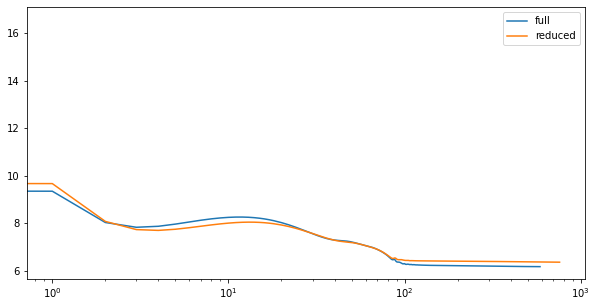

In [32]:
fig,ax = plt.subplots(1, figsize=(10,5))
ax.plot(gp.losses_, label='full')
ax.plot(gp_reduced.losses_, label='reduced')
ax.set_xscale('log')
ax.legend()

In [60]:
time = np.tile(np.arange(-10, 200, 2), 2)
genotype = np.repeat([0,1], len(time)/2)
x_pred = pd.DataFrame(dict(time=time, genotype=genotype))
percentiles = gp.predict(x_pred)

/Users/rensholmer/miniconda3/envs/jupyter/lib/python3.9/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
/Users/rensholmer/miniconda3/envs/jupyter/lib/python3.9/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
/Users/rensholmer/miniconda3/envs/jupyter/lib/python3.9/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
/Users/rensholmer/miniconda3/envs/jupyter/lib/python3.9/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


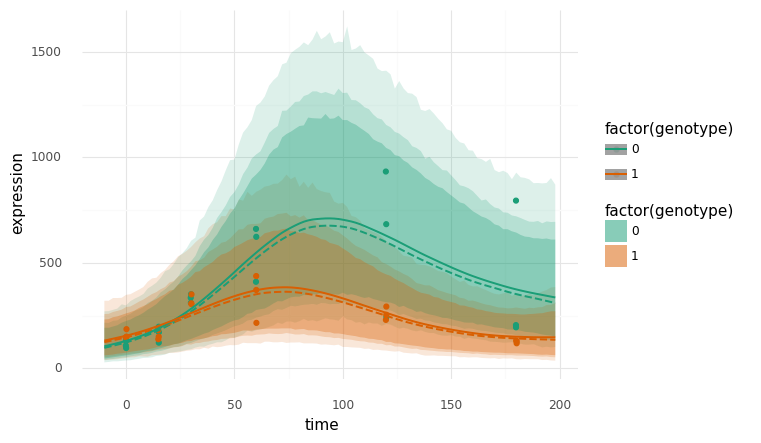

<ggplot: (674988270)>

In [74]:
train_df = pd.concat([gp.train_x_df,gp.train_y_df], axis=1)
train_df.columns = [*gp.variable_names,'expression']
test_df = pd.concat([x_pred, percentiles], axis=1)
train_aes = dict(x='time', color='factor(genotype)')
test_aes =  dict(x='time', fill='factor(genotype)')
(
    ggplot(train_df, aes(y='expression', **train_aes))
    + geom_ribbon(mapping=aes(**test_aes, ymin='p0.5', ymax='p99.5'), alpha=.15,
                 data=test_df, inherit_aes=False)
    + geom_ribbon(mapping=aes(**test_aes, ymin='p2.5', ymax='p97.5'), alpha=.2,
                 data=test_df, inherit_aes=False)
    + geom_ribbon(mapping=aes(**test_aes, ymin='p5', ymax='p95'), alpha=.3,
                 data=test_df, inherit_aes=False)
    + geom_jitter(width=.2)
    + geom_smooth(aes(**train_aes, y='p50'), method='lowess', span=.1, linetype='dashed', alpha=.7, size=.8,
                 data=test_df, inherit_aes=False)
    + geom_smooth(aes(**train_aes, y='mean'), method='lowess', span=.1, alpha=.7, size=.8,
                 data=test_df, inherit_aes=False)
    + theme_minimal()
    + scale_color_brewer('qual', 2)
    + scale_fill_brewer('qual', 2)
)

In [96]:
full_gp.likelihood(full_gp(full_gp.train_x)).log_prob(full_gp.train_y).mean(dim=0).sum().item()

-210.87655639648438

In [97]:
reduced_gp.likelihood(reduced_gp(reduced_gp.train_x)).log_prob(reduced_gp.train_y).mean(dim=0).sum().item()

-223.23846435546875

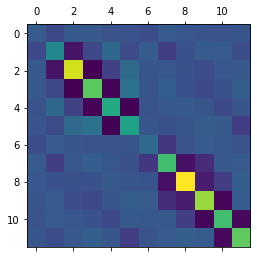

In [70]:
plt.matshow(gp.variational_strategy.variational_distribution.covariance_matrix.detach().numpy())

In [71]:
percentiles

,p0.5,p2.5,p5,p50,p95,p97.5,p99.5,mean
0,29.000,41.0,47.00,99.0,193.00,217.000,271.000,106.809402
1,31.000,43.0,50.00,103.0,193.00,216.000,272.010,109.900803
2,34.000,45.0,53.00,107.0,199.05,226.000,278.000,113.960602
3,34.000,48.0,56.00,111.0,205.00,228.000,284.005,118.579300
4,36.000,51.0,59.00,118.0,217.00,242.000,304.005,125.062599
...,...,...,...,...,...,...,...,...
205,43.995,57.0,66.00,138.0,261.00,290.000,355.000,147.042099
206,40.000,56.0,65.00,138.0,262.00,291.025,365.005,147.247299
207,41.000,57.0,65.95,138.0,267.00,301.000,372.005,148.633896
208,38.000,54.0,64.00,136.5,271.05,302.025,384.000,148.355103
